# ENSEMBLE LEARNING PCA-LDA

FACTS: 
Number of images in training set: N = 416 
Number of Pixels per image: D = 2576 
Number of classes: c = 52 
-> 
Sw: rank(Sw)= N-c = 364 -> Mpca <= 364 
Sb: rank(Sb)= c-1 = 51 -> Mlda <= 51

In [1]:
# Imports
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load the training and testing sets: 80% is training, 20% is testing

splittype = 'class'

if (splittype == 'whole'):
    training = np.loadtxt('split_whole_train.gzip', dtype = 'uint8')
    test = np.loadtxt('split_whole_test.gzip', dtype = 'uint8')
elif (splittype == 'class'):
    training = np.loadtxt('split_class_train.gzip', dtype = 'uint8')
    test = np.loadtxt('split_class_test.gzip', dtype = 'uint8')

In [3]:
# Define constants
TRAIN_RATIO = 0.8
CLASS_SIZE = 52 # number of classes
PIC_DIM = (46,56) # dimensions of picture
PIC_SIZE = PIC_DIM[0]*PIC_DIM[1]
TRAIN_SIZE = training.shape[0]
TEST_SIZE = test.shape[0]

In [4]:
# Ensemble constants
BAG_IM_SETS_NUM = 4 # number of bagged datasets
BAG_IM_CLASS_SIZE = 8 # number of pictures in each class 

BAG_CLASS_SETS_NUM = 0 # number of bagged datasets
BAG_CLASS_CLASS_NUM = 30 # number of classes considered for each data set

BAG_FEAT_SETS_NUM = 7 # number of bagged datasets
M0_M1_RATIO = 0.5

Kfold = 5


In [5]:
# Order training data depending on their class
training = training[np.argsort(training[:,-1]),:]

# Create a list of sets each with different bagged training data (repeated images)
bag_im_sets = []
for s in range(BAG_IM_SETS_NUM):
    set_t = np.zeros((CLASS_SIZE*BAG_IM_CLASS_SIZE,PIC_SIZE+1),dtype = 'uint8')
    for i in range(CLASS_SIZE):
        class_im_t = training[i==(training[:,-1]-1),:]
        np.random.shuffle(class_im_t)
        set_t[i*BAG_IM_CLASS_SIZE:(i*BAG_IM_CLASS_SIZE)+BAG_IM_CLASS_SIZE,:]=class_im_t[np.random.randint(0,8,size=BAG_IM_CLASS_SIZE),:]
    bag_im_sets.append(set_t)
    

# Create a list of sets each with different bagged training data (selected classes)
bag_class_sets = []
for s in range(BAG_CLASS_SETS_NUM):
    set_t = np.zeros((BAG_CLASS_CLASS_NUM*8,PIC_SIZE+1),dtype = 'uint8')
    index_row = 0
    for i in random.sample(range(52),BAG_CLASS_CLASS_NUM):
        class_im_t = training[i==(training[:,-1]-1),:]
        np.random.shuffle(class_im_t)
        set_t[index_row:index_row+8,:]=class_im_t
        index_row = index_row+8
    bag_class_sets.append(set_t)

In [6]:
def Get_Wopt(PCA, LDA, training):
    # Order training data depending on their class
    training = training[np.argsort(training[:,-1]),:]

    # Create a list of arrays depending on the classes
    class_sets = []
    for i in range(CLASS_SIZE):
        class_sets.append(training[i==(training[:,-1]-1),:PIC_SIZE]) # dimensions: numbers of pictures in each class x PIC_SIZE

    # Calculate the mean vector of each class
    class_means = np.zeros((CLASS_SIZE,PIC_SIZE))
    for i in range(CLASS_SIZE):
        class_means[i,:] = np.mean(class_sets[i], axis=0)

    # Calculate the global mean
    global_mean = np.mean(training[:,:PIC_SIZE], axis=0)
    
    # Compute Sb
    class_means_norm = class_means - global_mean # make use of broadcasting
    Sb = np.dot(class_means_norm.T, class_means_norm)
    
    # Compute x-mi
    class_sets_norm = []
    for i in range(CLASS_SIZE):
        class_sets_norm.append(class_sets[i]-class_means[i,:])

    # Compute Sw
    Sw = np.zeros((PIC_SIZE,PIC_SIZE))
    for c in class_sets_norm:
        Sw += np.dot(c.T,c)
    
    train_pic = training [:, :PIC_SIZE]
    train_pic_norm = train_pic - global_mean
    St = np.dot(train_pic_norm, train_pic_norm.T)
    
    # Compute Wpca
    # Find the eigenvalues of the St matrix
    eigvals_St, eigvecs_St = np.linalg.eig(St)

    # Take the real part of the eigenvalues (complex eigenvalues are the result of numerical rounding errors)
    eigvals_St = np.real(eigvals_St)
    # Take the real part and calculate the eigenvectors of the matrix A*A_T
    eigvecs_St = train_pic_norm.T.dot(np.real(eigvecs_St))
    eigvecs_St = eigvecs_St / np.linalg.norm(eigvecs_St,axis=0)

    # Order eigenvectors and eigenvalues according to their size
    index_St = (abs(eigvals_St)).argsort()[::-1]
    eigvals_St = eigvals_St[index_St]
    eigvecs_St = eigvecs_St[:,index_St]
    
    # Take the best PCA eigenvalues of St for computing Wpca_t
    eigvecs_St_best_t = eigvecs_St[:, :PCA]
    eigvals_St_best_t = eigvals_St[:PCA]

    #Define Wpca_t
    Wpca_t = eigvecs_St_best_t
    
    # Compute inverse of Sw_reduced times Sb_reduced
    LDA_inverse_t = np.linalg.inv(Wpca_t.T.dot(Sw).dot(Wpca_t)).dot(Wpca_t.T.dot(Sb).dot(Wpca_t))

    # Compute Wlda
    # Get the generalised eigenvectors of LDA_matrix with largest LDA eigenvalues
    eigvals_LDA_t, eigvecs_LDA_t = np.linalg.eig(LDA_inverse_t)

    # Take real part of the eigenvalues (complex eigenvalues are the result of numerical rounding errors)
    eigvals_LDA_t = np.real(eigvals_LDA_t)
    eigvecs_LDA_t = np.real(eigvecs_LDA_t)

    # Order eigenvectors and eigenvalues according to their size
    index_LDA_t = (abs(eigvals_LDA_t)).argsort()[::-1]
    eigvals_LDA_t = eigvals_LDA_t[index_LDA_t]
    eigvecs_LDA_t = eigvecs_LDA_t[:,index_LDA_t]

    # We just keep the first LDA eigenvectors and eigenvalues
    eigvecs_LDA_best_t = eigvecs_LDA_t[:, :LDA]
    eigvals_LDA_best_t = eigvals_LDA_t[:LDA]

    # Define Wlda
    Wlda_t = eigvecs_LDA_best_t
    
    Wopt_transposed_t = Wlda_t.T.dot(Wpca_t.T)
    return Wopt_transposed_t.T

In [7]:
def Get_Wopt_bag_class(PCA, LDA, training):
    # Order training data depending on their class
    training = training[np.argsort(training[:,-1]),:]
    
    class_size = int(training.shape[0]/8) #number of classes in the training set
    class_values = training[np.arange(0,training.shape[0],8),-1]

    # Create a list of arrays depending on the classes
    class_sets = []
    for i in range(class_size):
        class_sets.append(training[class_values[i]==training[:,-1],:PIC_SIZE]) # dimensions: numbers of pictures in each class x PIC_SIZE

    # Calculate the mean vector of each class
    class_means = np.zeros((class_size,PIC_SIZE))
    for i in range(class_size):
        class_means[i,:] = np.mean(class_sets[i], axis=0)

    # Calculate the global mean
    global_mean = np.mean(training[:,:PIC_SIZE], axis=0)
    
    # Compute Sb
    class_means_norm = class_means - global_mean # make use of broadcasting
    Sb = np.dot(class_means_norm.T, class_means_norm)
    
    # Compute x-mi
    class_sets_norm = []
    for i in range(class_size):
        class_sets_norm.append(class_sets[i]-class_means[i,:])

    # Compute Sw
    Sw = np.zeros((PIC_SIZE,PIC_SIZE))
    for c in class_sets_norm:
        Sw += np.dot(c.T,c)
    
    train_pic = training [:, :PIC_SIZE]
    train_pic_norm = train_pic - global_mean
    St = np.dot(train_pic_norm, train_pic_norm.T)
    
    # Compute Wpca
    # Find the eigenvalues of the St matrix
    eigvals_St, eigvecs_St = np.linalg.eig(St)

    # Take the real part of the eigenvalues (complex eigenvalues are the result of numerical rounding errors)
    eigvals_St = np.real(eigvals_St)
    # Take the real part and calculate the eigenvectors of the matrix A*A_T
    eigvecs_St = train_pic_norm.T.dot(np.real(eigvecs_St))
    eigvecs_St = eigvecs_St / np.linalg.norm(eigvecs_St,axis=0)

    # Order eigenvectors and eigenvalues according to their size
    index_St = (abs(eigvals_St)).argsort()[::-1]
    eigvals_St = eigvals_St[index_St]
    eigvecs_St = eigvecs_St[:,index_St]
    
    # Take the best PCA eigenvalues of St for computing Wpca_t
    eigvecs_St_best_t = eigvecs_St[:, :PCA]
    eigvals_St_best_t = eigvals_St[:PCA]

    #Define Wpca_t
    Wpca_t = eigvecs_St_best_t
    
    # Compute inverse of Sw_reduced times Sb_reduced
    LDA_inverse_t = np.linalg.inv(Wpca_t.T.dot(Sw).dot(Wpca_t)).dot(Wpca_t.T.dot(Sb).dot(Wpca_t))

    # Compute Wlda
    # Get the generalised eigenvectors of LDA_matrix with largest LDA eigenvalues
    eigvals_LDA_t, eigvecs_LDA_t = np.linalg.eig(LDA_inverse_t)

    # Take real part of the eigenvalues (complex eigenvalues are the result of numerical rounding errors)
    eigvals_LDA_t = np.real(eigvals_LDA_t)
    eigvecs_LDA_t = np.real(eigvecs_LDA_t)

    # Order eigenvectors and eigenvalues according to their size
    index_LDA_t = (abs(eigvals_LDA_t)).argsort()[::-1]
    eigvals_LDA_t = eigvals_LDA_t[index_LDA_t]
    eigvecs_LDA_t = eigvecs_LDA_t[:,index_LDA_t]

    # We just keep the first LDA eigenvectors and eigenvalues
    eigvecs_LDA_best_t = eigvecs_LDA_t[:, :LDA]
    eigvals_LDA_best_t = eigvals_LDA_t[:LDA]

    # Define Wlda
    Wlda_t = eigvecs_LDA_best_t
    
    Wopt_transposed_t = Wlda_t.T.dot(Wpca_t.T)
    return Wopt_transposed_t.T

In [8]:
def Do_PCA_LDA_KMEAN(Wopt_t, LDA, training):
    # Calculate the global mean
    global_mean = np.mean(training[:,:PIC_SIZE], axis=0)
    
    train_pic = training [:, :PIC_SIZE]
    train_pic_norm = train_pic - global_mean
    
    #Project training data into LDA space
    train_LDA_t = Wopt_t.T.dot(train_pic_norm.T) # each picture is represented by a column

    #Project test data into LDA space
    test_norm_t = (test[:,:PIC_SIZE] - global_mean)
    test_LDA_t = Wopt_t.T.dot(test_norm_t.T) #each picture is represented by a column
    
    coord_train_t = []
    for point in range(training.shape[0]):
        coord_train_t.append(train_LDA_t[:,point])
    

    coord_test_t = []
    for point in range(TEST_SIZE):
        coord_test_t.append(test_LDA_t[:,point])

    clf = svm.SVC()
    clf.fit(coord_train_t, training[:,PIC_SIZE])

    classes_predict_k_nn_t = clf.predict(coord_test_t)
    classes_act_NN = test[:,PIC_SIZE]

    return np.sum(classes_act_NN==classes_predict_k_nn_t) / classes_predict_k_nn_t.shape[0]

In [9]:
def Do_PCA_LDA_KMEAN_return_pred(Wopt_t, LDA, training):
    # Calculate the global mean
    global_mean = np.mean(training[:,:PIC_SIZE], axis=0)
    
    train_pic = training [:, :PIC_SIZE]
    train_pic_norm = train_pic - global_mean
    
    #Project training data into LDA space
    train_LDA_t = Wopt_t.T.dot(train_pic_norm.T) # each picture is represented by a column

    #Project test data into LDA space
    test_norm_t = (test[:,:PIC_SIZE] - global_mean)
    test_LDA_t = Wopt_t.T.dot(test_norm_t.T) #each picture is represented by a column
    
    coord_train_t = []
    for point in range(training.shape[0]):
        coord_train_t.append(train_LDA_t[:,point])
    

    coord_test_t = []
    for point in range(TEST_SIZE):
        coord_test_t.append(test_LDA_t[:,point])

    clf = svm.SVC()
    clf.fit(np.array(coord_train_t), training[:,PIC_SIZE])

    return clf.predict(coord_test_t)

In [10]:
def Do_PCA_LDA_KMEAN_return_prob(Wopt_t, LDA, K, training):
    # Calculate the global mean
    global_mean = np.mean(training[:,:PIC_SIZE], axis=0)
    
    train_pic = training [:, :PIC_SIZE]
    train_pic_norm = train_pic - global_mean
    
    #Project training data into LDA space
    train_LDA_t = Wopt_t.T.dot(train_pic_norm.T) # each picture is represented by a column

    #Project test data into LDA space
    test_norm_t = (test[:,:PIC_SIZE] - global_mean)
    test_LDA_t = Wopt_t.T.dot(test_norm_t.T) #each picture is represented by a column
    
    coord_train_t = []
    for point in range(training.shape[0]):
        coord_train_t.append(train_LDA_t[:,point])
    

    coord_test_t = []
    for point in range(TEST_SIZE):
        coord_test_t.append(test_LDA_t[:,point])
        
    clf = svm.SVC()
    clf.fit(np.array(coord_train_t), training[:,PIC_SIZE])

    neigh = KNeighborsClassifier(n_neighbors=K)
    neigh.fit(coord_train_t,training[:,PIC_SIZE])

    return neigh.predict_proba(coord_test_t)

In [11]:
def Do_PCA_LDA_NC(Wopt_t, LDA,training):
    class_size = int(training.shape[0]/8) #number of classes in the training set
    class_values = training[np.arange(0,training.shape[0],8),-1]

    # Create a list of arrays depending on the classes
    class_sets = []
    for i in range(class_size):
        class_sets.append(training[class_values[i]==training[:,-1],:PIC_SIZE]) # dimensions: numbers of pictures in each class x PIC_SIZE

    # Calculate the mean vector of each class
    class_means = np.zeros((class_size,PIC_SIZE))
    for i in range(class_size):
        class_means[i,:] = np.mean(class_sets[i], axis=0)

    # Calculate the global mean
    global_mean = np.mean(training[:,:PIC_SIZE], axis=0)
    
    # Compute Sb
    class_means_norm = class_means - global_mean # make use of broadcasting
    
    
    #Project training data into LDA space
    train_LDA_t = Wopt_t.T.dot(class_means_norm.T) # each picture is represented by a column

    #Project test data into LDA space
    test_norm_t = (test[:,:PIC_SIZE] - global_mean)
    test_LDA_t = Wopt_t.T.dot(test_norm_t.T) #each picture is represented by a column

    # Reshape and repeat matrices to allow easier manipulation
    train_LDA_reshape_NN_t = np.repeat(train_LDA_t.reshape(LDA,CLASS_SIZE,1),TEST_SIZE, axis=2) #afterwards: axis-0: projected values, axis-1: training pictures, axis-2: repeated values
    test_LDA_reshape_NN_t = np.repeat(test_LDA_t.reshape(LDA,1,TEST_SIZE), CLASS_SIZE, axis=1) #afterwards: axis-0: projected values, axis-1: repeated values, axis-2: test pictures

    # Compute nearest neighbours
    LDA_distances_t = np.linalg.norm(test_LDA_reshape_NN_t-train_LDA_reshape_NN_t, axis=0) # axis-0: training picture, axis-1: test picture

    # Determine the nearest classes
    classes_pred_NN_t = LDA_distances_t.argmin(axis=0)+1
    classes_act_NN = test[:,PIC_SIZE]

    # Determine the prediction accuracy
    return np.sum(classes_pred_NN_t==classes_act_NN) / classes_act_NN.shape[0]

In [12]:
def Do_PCA_LDA_NC_return_pred(Wopt_t, LDA,training):
    class_size = int(training.shape[0]/8) #number of classes in the training set
    class_values = training[np.arange(0,training.shape[0],8),-1]

    # Create a list of arrays depending on the classes
    class_sets = []
    for i in range(class_size):
        class_sets.append(training[class_values[i]==training[:,-1],:PIC_SIZE]) # dimensions: numbers of pictures in each class x PIC_SIZE

    # Calculate the mean vector of each class
    class_means = np.zeros((class_size,PIC_SIZE))
    for i in range(class_size):
        class_means[i,:] = np.mean(class_sets[i], axis=0)

    # Calculate the global mean
    global_mean = np.mean(training[:,:PIC_SIZE], axis=0)
    
    # Compute Sb
    class_means_norm = class_means - global_mean # make use of broadcasting
    
    
    #Project training data into LDA space
    train_LDA_t = Wopt_t.T.dot(class_means_norm.T) # each picture is represented by a column

    #Project test data into LDA space
    test_norm_t = (test[:,:PIC_SIZE] - global_mean)
    test_LDA_t = Wopt_t.T.dot(test_norm_t.T) #each picture is represented by a column

    # Reshape and repeat matrices to allow easier manipulation
    train_LDA_reshape_NN_t = np.repeat(train_LDA_t.reshape(LDA,CLASS_SIZE,1),TEST_SIZE, axis=2) #afterwards: axis-0: projected values, axis-1: training pictures, axis-2: repeated values
    test_LDA_reshape_NN_t = np.repeat(test_LDA_t.reshape(LDA,1,TEST_SIZE), CLASS_SIZE, axis=1) #afterwards: axis-0: projected values, axis-1: repeated values, axis-2: test pictures

    # Compute nearest neighbours
    LDA_distances_t = np.linalg.norm(test_LDA_reshape_NN_t-train_LDA_reshape_NN_t, axis=0) # axis-0: training picture, axis-1: test picture

    # Determine the nearest classes
    return LDA_distances_t.argmin(axis=0)+1

# FEATURE BAGGING 

In [13]:
def Get_Wopt_bag_feature(M0, M1, LDA, training):
    # Order training data depending on their class
    training = training[np.argsort(training[:,-1]),:]
    
    class_size = int(training.shape[0]/8) #number of classes in the training set
    class_values = training[np.arange(0,training.shape[0],8),-1]

    # Create a list of arrays depending on the classes
    class_sets = []
    for i in range(class_size):
        class_sets.append(training[class_values[i]==training[:,-1],:PIC_SIZE]) # dimensions: numbers of pictures in each class x PIC_SIZE

    # Calculate the mean vector of each class
    class_means = np.zeros((class_size,PIC_SIZE))
    for i in range(class_size):
        class_means[i,:] = np.mean(class_sets[i], axis=0)

    # Calculate the global mean
    global_mean = np.mean(training[:,:PIC_SIZE], axis=0)
    
    # Compute Sb
    class_means_norm = class_means - global_mean # make use of broadcasting
    Sb = np.dot(class_means_norm.T, class_means_norm)
    
    # Compute x-mi
    class_sets_norm = []
    for i in range(class_size):
        class_sets_norm.append(class_sets[i]-class_means[i,:])

    # Compute Sw
    Sw = np.zeros((PIC_SIZE,PIC_SIZE))
    for c in class_sets_norm:
        Sw += np.dot(c.T,c)
    
    train_pic = training [:, :PIC_SIZE]
    train_pic_norm = train_pic - global_mean
    St = np.dot(train_pic_norm, train_pic_norm.T)
    
    # Compute Wpca
    # Find the eigenvalues of the St matrix
    eigvals_St, eigvecs_St = np.linalg.eig(St)

    # Take the real part of the eigenvalues (complex eigenvalues are the result of numerical rounding errors)
    eigvals_St = np.real(eigvals_St)
    # Take the real part and calculate the eigenvectors of the matrix A*A_T
    eigvecs_St = train_pic_norm.T.dot(np.real(eigvecs_St))
    eigvecs_St = eigvecs_St / np.linalg.norm(eigvecs_St,axis=0)

    # Order eigenvectors and eigenvalues according to their size
    index_St = (abs(eigvals_St)).argsort()[::-1]
    eigvals_St = eigvals_St[index_St]
    eigvecs_St = eigvecs_St[:,index_St]
    
    M0_indices = np.arange(0,M0)
    M1_indices = np.array(np.array(random.sample(range(np.unique(training,axis=0).shape[0]-1-M0),M1)))+M0
    indices = np.append(M0_indices,M1_indices).astype('uint32')
    
    # Take the best PCA eigenvalues of St for computing Wpca_t
    eigvecs_St_best_t = eigvecs_St[:, indices]
    eigvals_St_best_t = eigvals_St[indices]

    #Define Wpca_t
    Wpca_t = eigvecs_St_best_t
    
    # Compute inverse of Sw_reduced times Sb_reduced
    LDA_inverse_t = np.linalg.inv(Wpca_t.T.dot(Sw).dot(Wpca_t)).dot(Wpca_t.T.dot(Sb).dot(Wpca_t))

    # Compute Wlda
    # Get the generalised eigenvectors of LDA_matrix with largest LDA eigenvalues
    eigvals_LDA_t, eigvecs_LDA_t = np.linalg.eig(LDA_inverse_t)

    # Take real part of the eigenvalues (complex eigenvalues are the result of numerical rounding errors)
    eigvals_LDA_t = np.real(eigvals_LDA_t)
    eigvecs_LDA_t = np.real(eigvecs_LDA_t)

    # Order eigenvectors and eigenvalues according to their size
    index_LDA_t = (abs(eigvals_LDA_t)).argsort()[::-1]
    eigvals_LDA_t = eigvals_LDA_t[index_LDA_t]
    eigvecs_LDA_t = eigvecs_LDA_t[:,index_LDA_t]

    # We just keep the first LDA eigenvectors and eigenvalues
    eigvecs_LDA_best_t = eigvecs_LDA_t[:, :LDA]
    eigvals_LDA_best_t = eigvals_LDA_t[:LDA]

    # Define Wlda
    Wlda_t = eigvecs_LDA_best_t
    
    Wopt_transposed_t = Wlda_t.T.dot(Wpca_t.T)
    return Wopt_transposed_t.T

# HIERARCHY

In [14]:
Dict_bag_hier = []
for s in bag_class_sets:
    Mpca_set = np.array([210])
    Mlda_set = np.array(random.sample(range(1,np.unique(s[:,-1]).shape[0]-1),5))
    prediction_accuracy = 0
    W = 0
    Mlda = 0
    Mpca = 0
    for p in range(Mpca_set.shape[0]):
        for l in range(Mlda_set.shape[0]):
            if Mlda_set[l]<=Mpca_set[p]:
                Wopt_t = Get_Wopt_bag_feature(int(Mpca_set[p]*M0_M1_RATIO),int(Mpca_set[p]*(1-M0_M1_RATIO)),Mlda_set[l],s)
                prediction_accuracy_t=Do_PCA_LDA_KMEAN(Wopt_t,Mlda_set[l],Kfold,s)
            else:
                Wopt_t = Get_Wopt_bag_feature(int(Mpca_set[p]*M0_M1_RATIO),int(Mpca_set[p]*(1-M0_M1_RATIO)),Mpca_set[p],s)
                prediction_accuracy_t=Do_PCA_LDA_KMEAN(Wopt_t,Mpca_set[p],Kfold,s)
            
            if prediction_accuracy_t > prediction_accuracy:
                prediction_accuracy = prediction_accuracy_t
                W = Wopt_t
                Mlda = Mlda_set[l]
                Mpca = Mpca_set[p]
    Dict_bag_hier.append({'Wopt':W,'Mlda':Mlda,'Mpca':Mpca})
    print("Prediction accuracy", prediction_accuracy)
    print("Mlda", Mlda)
    print("Mpca", Mpca)

# ENSEMBLE 

In [15]:
Dict_bag_im = []
for s in bag_im_sets:
    Mpca_set = np.array(random.sample(range(1,np.unique(s,axis=0).shape[0]-np.unique(s[:,-1]).shape[0]),5))
    Mlda_set = np.array(random.sample(range(1,np.unique(s[:,-1]).shape[0]-1),5))
    prediction_accuracy = 0
    W = 0
    Mlda = 0
    Mpca = 0
    for p in range(Mpca_set.shape[0]):
        for l in range(Mlda_set.shape[0]):
            if Mlda_set[l]<=Mpca_set[p]:
                Wopt_t = Get_Wopt_bag_class(Mpca_set[p],Mlda_set[l],s)
                prediction_accuracy_t=Do_PCA_LDA_KMEAN(Wopt_t,Mlda_set[l],training)
            else:
                Wopt_t = Get_Wopt_bag_class(Mpca_set[p],Mpca_set[p],s)
                prediction_accuracy_t=Do_PCA_LDA_KMEAN(Wopt_t,Mpca_set[p],training)
            
            if prediction_accuracy_t > prediction_accuracy:
                prediction_accuracy = prediction_accuracy_t
                W = Wopt_t
                Mlda = Mlda_set[l]
                Mpca = Mpca_set[p]
    Dict_bag_im.append({'Wopt':W,'Mlda':Mlda,'Mpca':Mpca})
    print("Prediction accuracy", prediction_accuracy)
    print("Mlda", Mlda)
    print("Mpca", Mpca)

Prediction accuracy 0.11538461538461539
Mlda 6
Mpca 134
Prediction accuracy 0.0673076923076923
Mlda 22
Mpca 169
Prediction accuracy 0.11538461538461539
Mlda 5
Mpca 163
Prediction accuracy 0.18269230769230768
Mlda 2
Mpca 52


In [16]:
Dict_bag_feat = []
for s in range(BAG_FEAT_SETS_NUM):
    Mpca_set = np.array([210])
    Mlda_set = np.array(random.sample(range(1,np.unique(training[:,-1]).shape[0]-1),5))
    prediction_accuracy = 0
    W = 0
    Mlda = 0
    Mpca = 0
    for p in range(Mpca_set.shape[0]):
        for l in range(Mlda_set.shape[0]):
            if Mlda_set[l]<=Mpca_set[p]:
                Wopt_t = Get_Wopt_bag_feature(int(Mpca_set[p]*M0_M1_RATIO),int(Mpca_set[p]*(1-M0_M1_RATIO)),Mlda_set[l],training)
                prediction_accuracy_t=Do_PCA_LDA_KMEAN(Wopt_t,Mlda_set[l],training)
            else:
                Wopt_t = Get_Wopt_bag_feature(int(Mpca_set[p]*M0_M1_RATIO),int(Mpca_set[p]*(1-M0_M1_RATIO)),Mpca_set[p],training)
                prediction_accuracy_t=Do_PCA_LDA_KMEAN(Wopt_t,Mpca_set[p],training)
            
            if prediction_accuracy_t > prediction_accuracy:
                prediction_accuracy = prediction_accuracy_t
                W = Wopt_t
                Mlda = Mlda_set[l]
                Mpca = Mpca_set[p]
    Dict_bag_feat.append({'Wopt':W,'Mlda':Mlda,'Mpca':Mpca})
    print("Prediction accuracy", prediction_accuracy)
    print("Mlda", Mlda)
    print("Mpca", Mpca)

Prediction accuracy 0.14423076923076922
Mlda 25
Mpca 210
Prediction accuracy 0.17307692307692307
Mlda 18
Mpca 210
Prediction accuracy 0.21153846153846154
Mlda 21
Mpca 210
Prediction accuracy 0.2692307692307692
Mlda 7
Mpca 210
Prediction accuracy 0.20192307692307693
Mlda 17
Mpca 210
Prediction accuracy 0.25961538461538464
Mlda 9
Mpca 210
Prediction accuracy 0.14423076923076922
Mlda 27
Mpca 210


<b>Fusion Majority

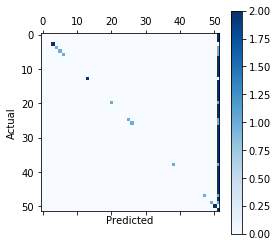

Prediction Accuracy: 0.16346153846153846


In [17]:
Models = Dict_bag_feat + Dict_bag_im
Prediction_matrix = np.zeros((len(Models),TEST_SIZE))
i_t = 0
for m in Models:
    Prediction_matrix[i_t,:] = Do_PCA_LDA_KMEAN_return_pred(m['Wopt'], m['Mlda'], training)
    i_t = i_t + 1

prediction_final = np.zeros((TEST_SIZE,), dtype=int)                                                              
for i in range(TEST_SIZE):
    counts = np.bincount(Prediction_matrix[:,i].astype('int'))
    prediction_final[i] = np.argmax(counts)

classes_act = test[:,PIC_SIZE]

# Print the corresponding confusion matrix
cm_PCA_LDA_ensemble = confusion_matrix(classes_act, prediction_final)

plt.matshow(cm_PCA_LDA_ensemble, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Determine the prediction accuracy
accuracy_PCA_LDA_NN_ensemble = np.sum(prediction_final==classes_act) / classes_act.shape[0]
print("Prediction Accuracy:",accuracy_PCA_LDA_NN_ensemble)
    

<b> Max Rule

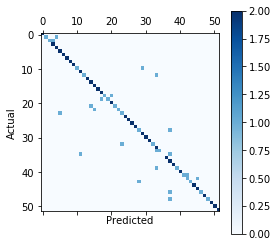

Prediction Accuracy: 0.8076923076923077


In [18]:
Prediction_matrix_max = np.zeros((len(Models),TEST_SIZE,2))
i_t = 0
for m in Models:
    proba = Do_PCA_LDA_KMEAN_return_prob(m['Wopt'], m['Mlda'], Kfold, training)
    Prediction_matrix_max[i_t,:,0] = np.argmax(proba,axis=1)+1 #class
    Prediction_matrix_max[i_t,:,1] = np.amax(proba,axis=1) #probability
    i_t = i_t + 1

prediction_final_max = np.zeros((TEST_SIZE,), dtype=int)                                                              
for i in range(TEST_SIZE):
    max_prob_class = np.argmax(Prediction_matrix_max[:,i,1])
    prediction_final_max[i] = Prediction_matrix_max[max_prob_class,i,0]

classes_act = test[:,PIC_SIZE]
# Print the corresponding confusion matrix
cm_PCA_LDA_ensemble_max = confusion_matrix(classes_act, prediction_final_max)

plt.matshow(cm_PCA_LDA_ensemble_max, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Determine the prediction accuracy
accuracy_PCA_LDA_NN_ensemble_max = np.sum(prediction_final_max==classes_act) / classes_act.shape[0]
print("Prediction Accuracy:",accuracy_PCA_LDA_NN_ensemble_max)

<b> Ensemble averaging

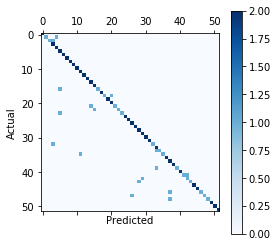

Prediction Accuracy: 0.8365384615384616


In [19]:
Prediction_matrix_av = np.zeros((TEST_SIZE,CLASS_SIZE))
i_t = 0
for m in Models:
    proba = Do_PCA_LDA_KMEAN_return_prob(m['Wopt'], m['Mlda'], Kfold, training)
    Prediction_matrix_av = Prediction_matrix_av + proba
    
Prediction_matrix_av = Prediction_matrix_av/len(m)

prediction_final_av = np.argmax(Prediction_matrix_av,axis=1)+1 #class

classes_act = test[:,PIC_SIZE]
# Print the corresponding confusion matrix
cm_PCA_LDA_ensemble_av = confusion_matrix(classes_act, prediction_final_av)

plt.matshow(cm_PCA_LDA_ensemble_av, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Determine the prediction accuracy
accuracy_PCA_LDA_NN_ensemble_av = np.sum(prediction_final_av==classes_act) / classes_act.shape[0]
print("Prediction Accuracy:",accuracy_PCA_LDA_NN_ensemble_av)